In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
import pickle
import baltic as bt
import json

In [2]:
tree_file = '../titer_model/shared_output/dengue_all_tree.json'
allEffects_err_file = '../titer_model/full_tree_model_output/predicted_titers.csv'
allEffects_performance_file = '../titer_model/full_tree_model_output/titer_model_performance.csv'
interseroEffects_err_file = '../titer_model/interserotype_model_output/predicted_titers.csv'
interserotypeEffects_performance_file = '../titer_model/interserotype_model_output/titer_model_performance.csv'

In [3]:
colors = pickle.load(open('./colors.p', 'rb'))

In [4]:
allEffects_err = pd.read_csv(allEffects_err_file, index_col=None)
interseroEffects_err = pd.read_csv(interseroEffects_err_file, index_col=None)

allEffects_perf = pd.read_csv(allEffects_performance_file, index_col=None)
interserotypeEffects_perf = pd.read_csv(interserotypeEffects_performance_file, index_col=None)

In [5]:
allEffects_perf['model'] = 'full tree'
interserotypeEffects_perf['model'] = 'interserotype'

performance = pd.concat([allEffects_perf, interserotypeEffects_perf])
performance.rename(columns={"r_squared": r'Pearson $R^2$', 'rms_error': 'Root mean\nsquared error'}, inplace=True)
performance = performance.melt(id_vars=['model'], value_vars=[r'Pearson $R^2$', 'Root mean\nsquared error'], 
                          value_name='value', var_name='metric')

In [7]:
tree = bt.loadJSON(tree_file, {'name': 'strain', 'height': 'div'})


Tree height: 0.463664
Tree length: 9.978979
annotations present

Numbers of objects in tree: 4716 (2149 nodes and 2567 leaves)



In [8]:
def is_interserotype(node):
    if node.branchType == 'leaf':
        return False
    descendents = node.leaves
    serotypes = [k.split('/')[0] for k in descendents]
    serotypes = [s for s in serotypes if s != 'DENV']
    return len(set(serotypes)) > 1

interserotype_branches = []
for k in tree.Objects:
    if is_interserotype(k):
        interserotype_branches.append(k)
        interserotype_branches += k.children
interserotype_branches = [ k.traits['clade'] for k in interserotype_branches]

In [8]:
def plot_tree(ll, ax, interserotype=False):
    sns.set(style='white',font_scale=1.2)

    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or from x position determined earlier
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if interserotype==True:
            if 'clade' in k.traits and k.traits['clade'] in interserotype_branches:
                branchWidth=2 ## default branch width
                c = colors['interserotype_effects']
            else:
                branchWidth=1
                c = 'lightgray'
        else:
            branchWidth=2
            c = colors['all_effects']

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            pass
#             s=50 ## tip size can be fixed
#             s=50-30*k.height/ll.treeHeight

#             ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
#             ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    ax.set_yticks([])
    ax.set_xticks([round(x, 2) for x in np.linspace(0, ll.treeHeight, 5)])
    ax.set_ylim(-5,ll.ySpan+7)
    ax.set_xlabel('Substitutions per site')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    
def plot_performance(performance, ax):
    sns.set(style='whitegrid',font_scale=1.2)
    sns.boxplot(x='metric', y='value', hue='model', data=performance, hue_order=['interserotype', 'full tree'], 
                palette=[colors['interserotype_effects'], colors['all_effects']], saturation=0.8)
#     sns.swarmplot(x='metric', y='value', hue='model', data=performance, hue_order=['interserotype', 'full tree'], 
#                   palette=[colors['interserotype_effects'], colors['all_effects']], dodge=True, alpha=0.8)
    ax.get_legend().remove()    
    ax.set_xlabel('')
    ax.set_ylabel('')
#     x,y=df['actual'], df['predicted']
#     sns.regplot(x,y, ax=ax, scatter_kws={'alpha': 0.3}, color=c)
#     fit = linregress(x,y)
#     r = fit[2]
#     rms_error=np.sqrt( sum([ (actual - predicted)**2 for (actual, predicted) in zip(x,y) ])/len(x))
#     ax.text(0.08, 0.9,r'Pearson $r = %.2f$'%r, transform=ax.transAxes)
#     ax.text(0.08, 0.8, r'rms error $= %.2f$'%rms_error, transform=ax.transAxes)
#     ax.set_xlabel('Observed log2(titer)')
#     ax.set_ylabel('Predicted log2(titer)')
#     ax.set_xlim(-5.5, 7.5)
#     ax.set_ylim(-5.5,7.5)


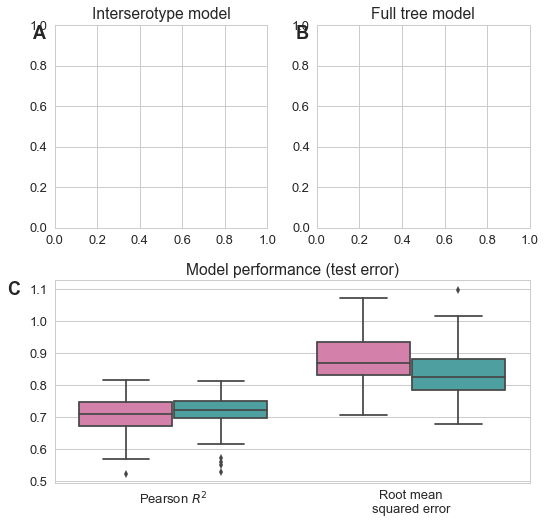

In [9]:
def add_subfigure_label(ax, label, x=-0.1, y=1.0):
    ax.text(x, y, label, va='top', fontdict={'fontsize': 18, 'fontweight': 'bold'}, transform=ax.transAxes)

plt.figure(figsize=(7.5,7.5))
sns.set(font_scale=1.3, style='whitegrid')
gs = gridspec.GridSpec(2,2)
interserotype_example_ax = plt.subplot(gs[0, 0])
full_tree_example_ax = plt.subplot(gs[0, 1])
performance_ax = plt.subplot(gs[1,:])

interserotype_example_ax.set_title('Interserotype model')
# plot_tree(tree, ax=interserotype_example_ax, interserotype=True)

full_tree_example_ax.set_title('Full tree model')
# plot_tree(tree, ax=full_tree_example_ax, interserotype=False)

performance_ax.set_title('Model performance (test error)')
plot_performance(performance, ax=performance_ax)

add_subfigure_label(interserotype_example_ax, 'A')
add_subfigure_label(full_tree_example_ax, 'B')
add_subfigure_label(performance_ax, 'C')

plt.tight_layout()
# plt.savefig('./png/titer_model_performance.png', dpi=300, bbox_inches='tight')

In [10]:
avg_performance = performance.groupby(['model', 'metric']).agg('mean')

In [11]:
print avg_performance

                                           value
model         metric                            
full tree     Pearson $R^2$             0.717765
              Root mean\nsquared error  0.833695
interserotype Pearson $R^2$             0.702545
              Root mean\nsquared error  0.879269
